In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import seaborn as sns
import warnings
from sklearn.linear_model import Lasso
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("winemag-data-130k-v2.csv")

##  Visualization 1-2

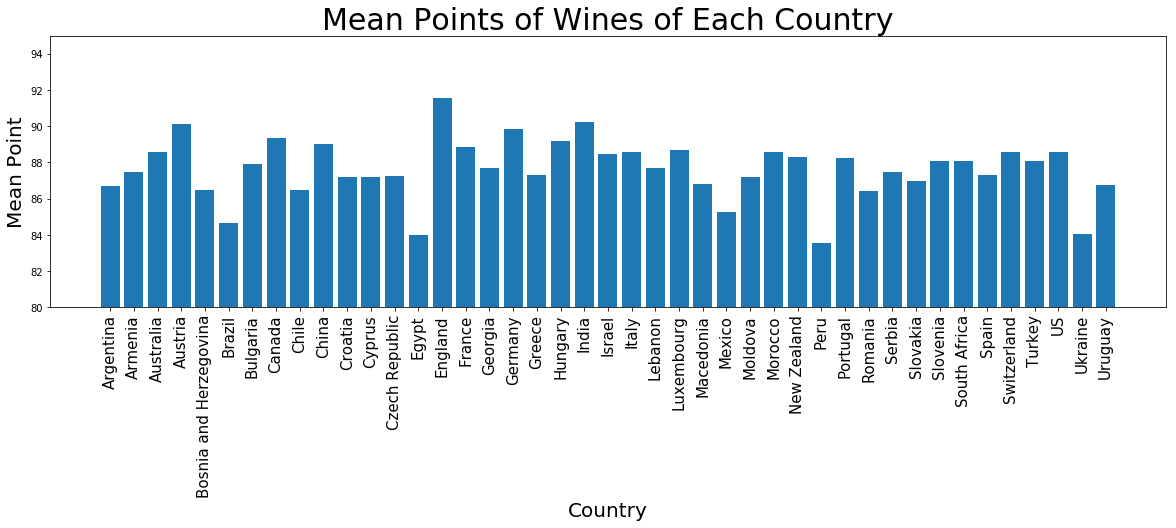

In [4]:
mean_points = data.groupby("country").mean()[["points"]]
plt.figure(figsize=(20,5))
plt.bar(list(mean_points.index), list(mean_points["points"]))
plt.ylabel("Mean Point", fontsize = 20)
plt.xlabel("Country", fontsize = 20)
plt.xticks(rotation=90,fontsize = 15)
plt.ylim(80,95)
plt.title("Mean Points of Wines of Each Country", fontsize = 30)
plt.show()

The bar plot encode Mean Points of Wines and Country with line mark and position channel, which can help us look up and compare mean points of wines. Foreground-background separation is good and the color does not have much impact on the information the plot is to convey. We can see that the wines from Brazil, Peru, Ukraine have relatively low points. There is no significant difference between wines from other countries.

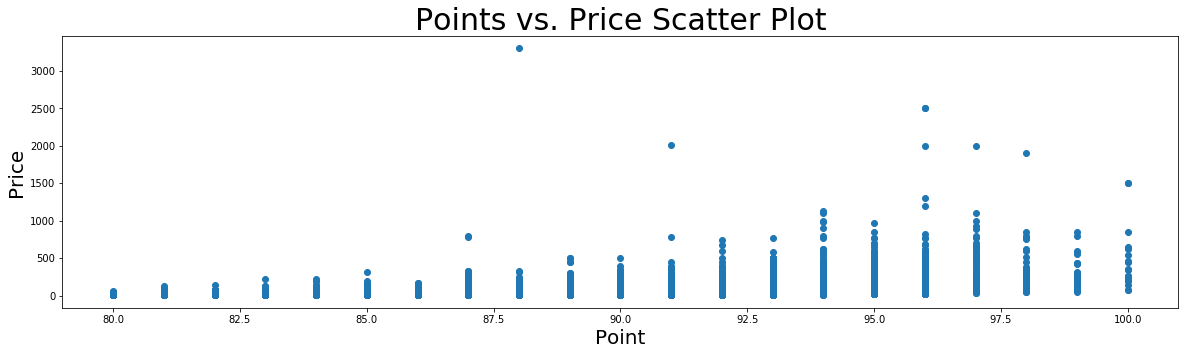

In [5]:
plt.figure(figsize=(20,5))
plt.plot(list(data["points"]), list(data["price"]), "o")
plt.ylabel("Price", fontsize = 20)
plt.xlabel("Point", fontsize = 20)
plt.title("Points vs. Price Scatter Plot", fontsize = 30)
plt.show()

The scatter chart encode Point and Price with point marks and position channel. It can help us find the distribution and correlation between Point and Price. The color choice and Foreground-background separation is appropriate, which makes the points identifiable. Price has a positive relationship with Point, the wines with highest points don't have the highest price. The most expensive wine have points between 87 and 90.

## Data Preprocessing

In [37]:
# Data Cleaning
data = data.drop(columns = ['Unnamed: 0','region_2', 'designation', "region_1", "taster_name", "taster_twitter_handle", 'title', "winery"])
data = data.dropna()
data = data.drop_duplicates()
data = data.sample(n = 5000)
data = data.reset_index(drop=True)
data = pd.get_dummies(data, columns=['country', "province", "variety"])

In [38]:
# Remove stop words, lemmatize, remove unprintable words
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    def preprocess_sent(sent):
        sent = " ".join([lemmatizer.lemmatize(word.lower()) 
                         for word in nltk.word_tokenize(sent) 
                         if (word not in stop_words) 
                         and word.isalpha()])
        return sent
    sents = sent_tokenize(text)
    sent_lst = [preprocess_sent(sents[i]) for i in range(len(sents))]
    return " ".join(sent_lst)
for i in range(len(data)):
    data["description"][i] = preprocess_text(data["description"][i])

In [25]:
# Split the dataset randomly into train/test 
train, test = train_test_split(data, test_size=0.2, random_state = 0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Standardize 
scaler = StandardScaler()
train[['price','points']] = scaler.fit_transform(train[['price','points']])
test[['price','points']] = scaler.transform(test[['price','points']])
train_x, train_y = train.drop(columns = ['points']), list(train['points'])
test_x, test_y = test.drop(columns = ['points']), list(test['points'])

train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)

In [26]:
# TFIDF
vectorizer = TfidfVectorizer(sublinear_tf = True)
train_descrip = vectorizer.fit_transform(train_x.description)
test_descrip = vectorizer.transform(test_x.description)
# LDA
n_topic = 10
lda = LDA(n_components=n_topic)
train_descrip = lda.fit_transform(train_descrip)
test_descrip = lda.transform(test_descrip)
# Update Datasets

In [27]:
train_prob = pd.DataFrame({str(i+1): train_descrip[:,i] for i in range(train_descrip.shape[1])})
test_prob = pd.DataFrame({str(i+1): test_descrip[:,i] for i in range(test_descrip.shape[1])})
train_x = pd.concat([train_x, train_prob], axis = 1).drop(columns = ["description"])
test_x = pd.concat([test_x, test_prob], axis = 1).drop(columns = ["description"])
feature_names = np.array(train_x.columns)
train_x = train_x.values
test_x = test_x.values

1. Remove stop words, lemmatize, remove unprintable words to get more accurate TFIDF score.

2. Region_2 is removed since it is available only for US. taster_name and taster_twitter_handle are one to one, thus highly correlated, I only used taster_name. designation, winery, title are removed since their number of unique values are so big that it may cause overfitting problem. region_1 and taster_name are removed since there are to many na values.

3. Fit and convert the descriptions in the training set into TFIDF matrix, then convert the descriptions in test set correpond correspondingly. Apply LDA to the TFIDF matrix of train set, then transform the TFIDF matrix of test set correspondingly. Add the possibilities of latent topics to the previous data frame.

## Modeling 

### Ridge Regression

In [7]:
alpha = np.linspace(0.2, 10, 50)
ridge_rmse = []
min_rmse_ridge = 10000
param_ridge = 0
for item in alpha:
    ridge = Ridge(alpha=item)
    ridge_scores = cross_validate(ridge, train_x, train_y, cv=10, 
                   scoring=('neg_mean_absolute_error'),
                   return_train_score=False)['test_score']
    ridge_rmse.append(np.sqrt(np.abs(ridge_scores)))  
    if np.mean(ridge_rmse[-1]) < min_rmse_ridge:
        min_rmse_ridge = np.mean(ridge_rmse[-1])
        param_ridge = item
        score_ridge = ridge_rmse[-1]
print("Ridge Regression:","best_alpha: %.2f,"%(param_ridge), "RMSE: %.4f."%(min_rmse_ridge))

Ridge Regression: best_alpha: 7.80, RMSE: 0.8218.


### Lasso Regression

In [10]:
alpha = np.linspace(0.2, 10, 50)
lasso_rmse = []
min_rmse_lasso = 10000
param_lasso = 0
for item in alpha:
    lasso = Lasso(alpha=item)
    lasso_scores = cross_validate(lasso, train_x, train_y, cv=10, 
                   scoring=('neg_mean_absolute_error'),
                   return_train_score=False)['test_score']
    lasso_rmse.append(np.sqrt(np.abs(lasso_scores)))  
    if np.mean(lasso_rmse[-1]) < min_rmse_lasso:
        min_rmse_lasso = np.mean(lasso_rmse[-1])
        param_lasso = item
        score_lasso = lasso_rmse[-1]
print("Lasso Regression:","best_alpha: %.2f,"%(param_lasso), "RMSE: %.4f."%(min_rmse_lasso))

Lasso Regression: best_alpha: 0.20, RMSE: 0.8625.


### Gradient Boosting Regression

In [12]:
n_trees = np.linspace(10, 100, 10)
max_depths = np.linspace(5, 50, 10)
gbr_rmse = []
min_rmse_gbr = 10000
param_gbr = 0
score_gbr = 1000
for n in n_trees:
    for depth in max_depths:
        GBR = GradientBoostingRegressor(n_estimators=int(n), max_depth = int(depth),
                                        random_state=0)
        gbr_scores = cross_validate(GBR, train_x, train_y, cv=10, 
                   scoring=('neg_mean_absolute_error'),
                   return_train_score=False)['test_score']
        gbr_rmse.append(np.sqrt(np.abs(gbr_scores)))   
        if np.mean(gbr_rmse[-1]) < min_rmse_gbr:
            min_rmse_gbr = np.mean(gbr_rmse[-1])
            param_gbr = [n, depth]
            score_gbr = gbr_rmse[-1]
print("Gradient Boosting Regression:","best_c: %.2f,"%(param_gbr[0]), 
      "best_epsilon: %.2f,"%(param_gbr[1]), "RMSE: %.4f."%(min_rmse_gbr))

Gradient Boosting Regression: best_c: 50.00, best_epsilon: 5.00, RMSE: 0.7234.


I used grid search to find the optimal hyperparameters for all three models because the number of possible combination of parameters is not big.

### Visualization 3

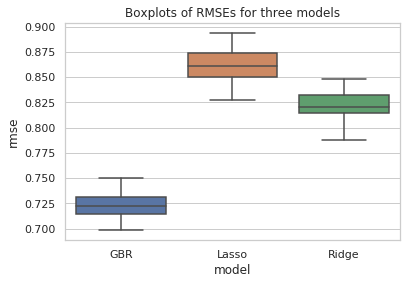

In [7]:
frame = {"rmse": score_gbr + score_lasso + score_ridge, 
         "model": ["GBR"]*10 +["Lasso"]*10 + ["Ridge"]*10}
frame = pd.DataFrame(frame)

sns.set(style="whitegrid")
sns.boxplot(x="model", y="rmse", data = frame)
plt.title("Boxplots of RMSEs for three models")
plt.show()

The boxplot is able to encode and visualize multiple quantitative attribute. The plot above encode the RMSEs on 10 folds for three models with vertial spatial channel and 1d list alignment of glyphs. The colors is vivid and contrast with the white background, and they guide people's attention to the difference between models. \cite(P335 VAD) From the plot, we can see the Gradient Boosting Regression has the minimum RMSEs on 10 folds.

### RMSE on Test Set

In [21]:
ridge_best = Ridge(alpha=7.8)
ridge_best.fit(test_x, test_y)
print("Ridge Regression Test RMSE: %.2f"%np.sqrt(mean_squared_error(ridge_best.predict(test_x),test_y)))

lasso_best = Lasso(alpha=0.2)
lasso_best.fit(test_x, test_y)
print("Lasso Regression Test RMSE: %.2f"%np.sqrt(mean_squared_error(lasso_best.predict(test_x),test_y)))

GBR_best = GradientBoostingRegressor(n_estimators=50, max_depth = 5, random_state=0)
GBR_best.fit(test_x, test_y)
print("Gradient Boosting Regression Test RMSE: %.2f"%np.sqrt(mean_squared_error(GBR_best.predict(test_x),test_y)))

Ridge Regression Test RMSE: 0.80
Lasso Regression Test RMSE: 0.91
Gradient Boosting Regression Test RMSE: 0.47


Gradient Boosting Regression has the best performance on test set.

### Visualization 4

In [47]:
feature_importance = GBR_best.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(10) + .5)

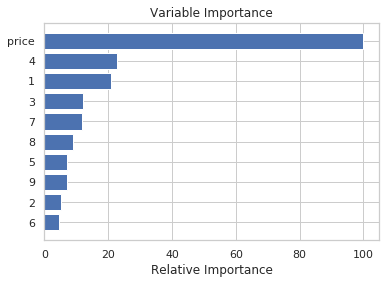

In [48]:
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The bar plot above encodes the quantitive attribute, feature relative importance, and the categorical attribute, top features, with line marks and position channel. Foreground-background separation is good. It can help people to compare values. \cite(P151 VAD). From the plot, we can see that price and latent topics of description play essential roles in predicting wine scores.